In [1]:
import random
import requests
import numpy as np
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import transform as shaptransform
from pyproj import CRS, Transformer

import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from matplotlib import font_manager
from matplotlib import pyplot, transforms
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
def lonlat_to_utm(lon, lat):
    if lat < 0:
        return int(32700 + np.floor((180+lon)/6) + 1)
    else:
        return int(32600 + np.floor((180+lon)/6) + 1)

In [3]:
def get_highways():
    # Overpass-turbo query for highway=*
    query_highway = "[out:json][timeout:25];"
    query_highway += f"way[\"highway\"]{lat_min, lon_min, lat_max, lon_max};"
    query_highway += "out geom;"
    
    # Request data from overpass-turbo
    overpass_request = requests.get(overpass_url, params={"data": query_highway})

    # Get the json object from the request
    features = overpass_request.json()
    lines = {}
    for i, feature in enumerate(features["elements"]):
        line = []
        for pts in feature["geometry"]:
            line.append((pts["lon"], pts["lat"]))
        line_prj = shaptransform(project, LineString(line))
        if extent_poly.contains(line_prj):
            lines[i] = {}
            lines[i]["geometry"] = np.array(line_prj.coords[:])
            lines[i]["type"] = feature["tags"]["highway"]
            lines[i]["name"] = feature["tags"].get("name", None)
    return lines

In [4]:
def get_buildings():
    # Overpass-turbo query for building = *
    query_buildings = "[out:json][timeout:25];"
    query_buildings += f"way[\"building\"]{lat_min, lon_min, lat_max, lon_max};"
    query_buildings += "out geom;"
    
    # Request data from overpass-turbo
    overpass_request = requests.get(overpass_url, params={"data": query_buildings})

    # Get the json object from the request
    features = overpass_request.json()
    polygons = {}
    for i, feature in enumerate(features["elements"]):
        polygon = []
        for pts in feature["geometry"]:
            polygon.append((pts["lon"], pts["lat"]))
        poly_prj = shaptransform(project, Polygon(polygon))
        if extent_poly.contains(poly_prj):
            polygons[i] = {}
            polygons[i]["geometry"] = np.array(poly_prj.exterior.coords[:])
            polygons[i]["name"] = feature["tags"].get("name", None)
    return polygons

In [5]:
def extrude(geom, heigth=0.02):
    extruded = []
    for point_A, point_B in zip(geom[:-1], geom[1:]):
        surface = []
        surface.append((point_A[0], point_A[1], heigth))
        surface.append((point_B[0], point_B[1], heigth))
        surface.append((point_B[0], point_B[1], 0))
        surface.append((point_A[0], point_A[1], 0))
        surface.append((point_A[0], point_A[1], heigth))
        extruded.append(surface)
    return extruded

In [6]:
# Load fonts
title_font = r"fonts\Metal Gear Regular.ttf"
text_font = r"fonts\000webfont.ttf"

title_prop = font_manager.FontProperties(fname=title_font)
text_prop = font_manager.FontProperties(fname=text_font)

In [7]:
overpass_url = "http://overpass-api.de/api/interpreter"

In [8]:
lon_min = 12.439055442810059
lat_min = 41.86982447671587
lon_max = 12.443153858184814
lat_max = 41.87271656287565

In [9]:
utm_zone = lonlat_to_utm(lon_min, lat_min)

In [10]:
wgs84_crs = CRS('EPSG:4326')
utm_crs = CRS(utm_zone)
project = Transformer.from_crs(wgs84_crs, utm_crs, always_xy=True).transform

In [11]:
lonlat_min = shaptransform(project, Point(lon_min, lat_min))
lonlat_max = shaptransform(project, Point(lon_max, lat_max))

In [12]:
xmin = lonlat_min.x
ymin = lonlat_min.y
xmax = lonlat_max.x
ymax = lonlat_max.y
extent_arr = [(xmin, ymin), (xmax, ymin), (xmax, ymax),
              (xmin, ymax), (xmin, ymin)]
extent_poly = Polygon(extent_arr)

In [13]:
widthx = 10
widthy = 10

# Columns/rows
columns = range(int(np.floor(xmin)), int(np.ceil(xmax)), widthx)
rows = range(int(np.floor(ymin)), int(np.ceil(ymax)), widthy)[::-1]
grids = [np.array([(x, y, -0.008), 
                   (x + widthx, y, -0.008), 
                   (x + widthx, y - widthy, -0.008), 
                   (x, y - widthy, -0.008)]) 
         for x in columns for y in rows]

In [14]:
buildings = get_buildings()
highwways = get_highways()

In [15]:
elev = 0.05
marker_size = 25

In [16]:
# Colors
minmap_spine = (30/255, 176/255, 139/255)
minmap_building_edg = (17/255, 217/255, 108/255)
minmap_building_fc = (0, 0, 0, 0)

enemy_edg = (44/255, 174/255, 210/255)
enemy_fc = (44/255, 174/255, 210/255)

camera_edg = (146/255, 205/255, 79/255)
camera_fc = (146/255, 205/255, 79/255)

snake_fc = "white"
snake_edg = "white"

grid_fc = (3.0/255, 8/255, 12/255)
grid_edg = (30/255, 176/255, 139/255)

ax_fc = (3.0/255, 8/255, 12/255)

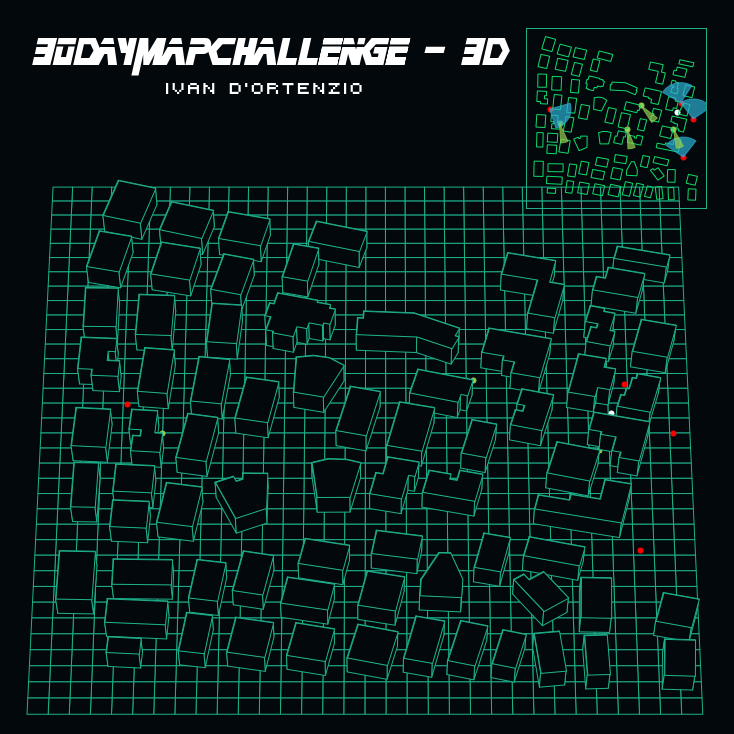

In [17]:
# Plot the result
fig = plt.figure(figsize=(10, 10))
ax_3d = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax_3d)

# Add the title
ax_3d.annotate('3ODayMapChallenge - 3D', color = "white",
            xy=(0.36, 0.93), xytext=(0, 0),
            xycoords=('axes fraction', 'figure fraction'),
            textcoords='offset points',
            font_properties=title_prop,
            size=30, ha="center")

ax_3d.annotate('Ivan D\'Ortenzio', color = "white",
            xy=(0.36, 0.89), xytext=(0, 0),
            xycoords=('axes fraction', 'figure fraction'),
            textcoords='offset points',
            font_properties=text_prop,
            size=35, ha="center")

# Create the 2D MAP
ax_map = fig.add_axes([0.72, 0.72, 0.25, 0.25])
base = pyplot.gca().transData
rotat = transforms.Affine2D().rotate_deg(-90)
for k, data in buildings.items():
    geom2d = data["geometry"]
    ax_map.fill(geom2d[:,0], geom2d[:,1], lw=1.0, 
             edgecolor=minmap_building_edg, 
             facecolor=minmap_building_fc, 
             transform=rotat + base)
for spine in ax_map.spines.values():
    spine.set_edgecolor(minmap_spine)
    spine.set_linewidth(1)
ax_map.set_facecolor((0, 0 , 0, 0))
ax_map.get_xaxis().set_visible(False)
ax_map.get_yaxis().set_visible(False)

# Add Enemies
for _ in range(4):
    while(True):
        rand_highway = random.choice([g["geometry"] for g in highwways.values()])
        cx, cy = rand_highway[random.randint(0, len(rand_highway) - 1)]
        if (xmin + 10 < cx < xmax - 10) and (ymin + 10 < cy < ymax - 10):
            break
    rand_1 = random.randint(0, 180)
    rand_2 = (rand_1 + 90) % 360
    visual_cone = Wedge((cx, cy), 40, rand_1, rand_2,edgecolor=enemy_edg,
            facecolor=enemy_edg, alpha=0.7, transform=rotat + base)
    ax_map.add_artist(visual_cone)
    ax_map.scatter(cx, cy, color="red", transform=rotat + base, s=marker_size)
    ax_3d.scatter3D(cx, cy, 0.01, color="red", s=marker_size)
    
    
# Add Cameras
for _ in range(4):
    while(True):
        rand_highway = random.choice([g["geometry"] for g in buildings.values()])
        cx, cy = rand_highway[random.randint(0, len(rand_highway) - 1)]
        if (xmin + 10 < cx < xmax - 10) and (ymin + 10 < cy < ymax - 10):
            break  
    rand_1 = random.randint(0, 90)
    rand_2 = (rand_1 + 20) % 360
    visual_cone = Wedge((cx, cy), 40, rand_1, rand_2, edgecolor=camera_edg,
            facecolor=camera_fc, alpha=0.7, transform=rotat + base)
    ax_map.add_artist(visual_cone)
    ax_map.scatter(cx, cy, color=camera_fc, transform=rotat + base, s=marker_size)
    ax_3d.scatter3D(cx, cy, elev, color=camera_fc, s=marker_size)
    
# Add Solid Snake
rand_highway = random.choice([geom["geometry"] for geom in highwways.values()])
cx, cy = rand_highway[random.randint(0, len(rand_highway) - 1)]
if (xmin + 10 < cx < xmax - 10) and (ymin + 10 < cy < ymax - 10):
    ax_3d.scatter3D(cx, cy, 0.01, color=snake_fc, s=marker_size)
    ax_map.scatter(cx, cy, color=snake_fc, transform=rotat + base, s=marker_size)

# Add the grid
for grid in grids:
    grid_3d = [list(zip(grid[:, 0], grid[:, 1], grid[:, 2]))]
    grid_3d = Poly3DCollection(grid_3d, lw=1, edgecolor=grid_edg, facecolor=grid_fc)
    ax_3d.add_collection3d(grid_3d)
    
# Add the buildings
for k, data in buildings.items():
    # Add extruded polygon
    geom = data["geometry"]        
    geom3d = extrude(geom, elev)
    geom3d = Poly3DCollection(geom3d, lw=1, edgecolor=grid_edg, facecolor=grid_fc)
    ax_3d.add_collection3d(geom3d)
    
    # Add roof
    top3d = np.hstack((geom, np.full((geom.shape[0], 1), elev)))
    top3d = [list(zip(top3d[:, 0], top3d[:, 1], top3d[:, 2]))]
    top3d = Poly3DCollection(top3d,
                              lw=1,
                              edgecolor=grid_edg,
                              facecolor=grid_fc)
    ax_3d.add_collection3d(top3d)
    
# Set map limits
ax_3d.set_xlim(xmin, xmax)
ax_3d.set_ylim(ymin, ymax)

# Remove tick labels
ax_3d.set_xticklabels([])
ax_3d.set_yticklabels([])
ax_3d.set_zticklabels([])

# Transparent spines
ax_3d.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax_3d.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax_3d.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Transparent panes
ax_3d.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax_3d.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax_3d.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# No grid
ax_3d.grid(False)

# No ticks
ax_3d.set_xticks([]) 
ax_3d.set_yticks([]) 
ax_3d.set_zticks([])

# Facecolor
ax_3d.set_facecolor(ax_fc)
fig.set_facecolor(ax_fc)

ax_3d.view_init(60, 0)
ax_3d.set_xlim3d(xmin+50,xmax-50)
ax_3d.set_ylim3d(ymin+50, ymax-50)
ax_3d.set_zlim3d(0, 0.5)
plt.show()

# Save the figure
fig.savefig("11_3D.png", dpi=300)